# CMSC320 Final Tutorial

Lucrecio Alberto, Kyle Herock, Stephanie Verduguez

## Introduction

In this tutorial, we will be analyzing wines all over the world and learning more about which countries produce the best wine. We will first clean the data up so it will be easy to work with. The data set we are using contains information about each wine's origin, its type (e.g Merlot), and its score on Wine Magazine. We will do some exploratory data analysis (EDA) to learn and visualize trends in the data. Is a more expensive wine better than a cheaper one? How much does the age of the wine matter?

The highlight of this tutorial should be a good example of partitioning data to perform piecewise regression.

## Libraries

This tutorial uses some libraries commonly used when doing analysis with Python. You'll need them installed if you want to run the code used in this tutorial yourself.
* [NumPy](http://www.numpy.org/)
* [Pandas](http://pandas.pydata.org/)
* [Seaborn](https://seaborn.pydata.org/) (wrapper around [Matplotlib](https://matplotlib.org/))
* [StatsModels](http://www.statsmodels.org/)

We'll need to import these at the beginning before we do anything else:

In [22]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf

# Allow figures to render inline in the notebook
%matplotlib inline
mpl.rcParams['figure.dpi'] = 96

## Getting Started
First, we need to download the dataset. A download can be found [here](https://www.kaggle.com/zynicide/wine-reviews/data), however this tutorial references our own hosted copy of the dataset. More info (and source code!) about how this data was scraped can be found [here](https://github.com/zackthoutt/wine-deep-learning). It is the first 130 thousand reviews scraped from [WineEnthusiast](http://www.winemag.com/?s=&drink_type=wine). The data comes in a comma separated values (.csv) file which we can use the pandas library to parse. Pandas will return a [`DataFrame`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.html) object which acts as a table we can work with. Empty values in the CSV are replaced with `NaN` values in the `DataFrame`.

## Data Cleaning

After reading in the csv, we noticed we can drop some of the columns we aren't planning to use for this tutorial. We can use `pandas.DataFrame.drop()` to remove the two region columns. Keeping the province and the country columns could prove useful if we would like to dive down deeper at a specfic country. As you can see, we have about 130 thousand entries which we will try to prune. We print out the head of the table below just to show a small sample of what the table looks like. 

In [23]:
# import the dataset via URL
data = pd.read_csv('https://320-lasvkh.github.io/winemag-data-130k-v2.csv', index_col=0)
# drop unused columns
data = data.drop(['region_1', 'region_2', 'taster_twitter_handle'], axis=1)
original_dataset_size = len(data)
print('Original size of dataset: %d rows' % original_dataset_size)
data.head()

Original size of dataset: 129971 rows


,country,description,designation,points,price,province,taster_name,title,variety,winery
0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Kerin O’Keefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,Roger Voss,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Paul Gregutt,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Alexander Peartree,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Paul Gregutt,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks


In [24]:
# pandas conveniently has a drop_duplicates() function that does what we need
# But to print a table that shows just only duplicate rows, we'll use DataFrame.groupby()
dupes = data.groupby('description')

dupes = pd.concat(g[1] for g in dupes if len(g[1]) > 1)
dupes.head()

,country,description,designation,points,price,province,taster_name,title,variety,winery
46540,US,"100% Malbec, it's redolent with dark plums, wi...",NaN,87,20.0,Washington,Sean P. Sullivan,Roza Ridge 2010 Malbec (Rattlesnake Hills),Malbec,Roza Ridge
67614,US,"100% Malbec, it's redolent with dark plums, wi...",NaN,87,20.0,Washington,Sean P. Sullivan,Roza Ridge 2010 Malbec (Rattlesnake Hills),Malbec,Roza Ridge
72181,US,"100% Sangiovese, this pale pink wine has notes...",Meadow,88,18.0,Washington,Sean P. Sullivan,Ross Andrew 2013 Meadow Rosé (Columbia Valley ...,Rosé,Ross Andrew
119702,US,"100% Sangiovese, this pale pink wine has notes...",Meadow,88,18.0,Washington,Sean P. Sullivan,Ross Andrew 2013 Meadow Rosé (Columbia Valley ...,Rosé,Ross Andrew
73731,France,"87-89 Barrel sample. A pleasurable, perfumed w...",Barrel sample,88,NaN,Bordeaux,Roger Voss,Château Lalande-Borie 2008 Barrel sample (Sai...,Bordeaux-style Red Blend,Château Lalande-Borie


We have a lot of duplicate entries that we can get rid of here. In addtion, we'll want to remove any entries in the table where we have `NaN` in important fields in the next section. In total we are eliminating ~23k rows. 

In [25]:
data = data.drop_duplicates('description')

print('Dropped %d rows' % (original_dataset_size - len(data)))
print('New dataset size: %d' % len(data))

Dropped 10016 rows
New dataset size: 119955


It will probably be good to know how old the wine is (hint: it gets better with age!). Though our data set doesn't provide it directly, we can extract by deconstructing values in the `title` column. It is good to note that many wineries have a year in their name (Don Cristobal 1492 for instance), so we'll want to remove the beginning of the title using the winery name availalbe in the `winery` column. There are also a few points that are missing years and have 'NV' where the year should be, so we'll drop those.

We will add this new column `age` relative to 2017 to our DataFrame so we can visualize wine getting older in a more natural way.

In [26]:
# omit the beginning of the titles since Winery names often have years in them
data['year'] = pd.to_numeric(data.apply(lambda x: x.title[len(x.winery) + 1:len(x.winery) + 5], axis=1), errors='coerce')

# drop rows with NaN price, country, or year
data = data.dropna(subset=['price', 'country', 'year'])

data['year'] = data['year'].astype(int)

# drop the title and description columns since they don't provide much value to our analysis after this
data = data.drop(['title', 'description'], axis=1)
data['age'] = 2017 - data['year']

print('Dropped %d rows total' % (original_dataset_size - len(data)))
print("New dataset size: %d" % len(data))
data.head()

Dropped 22299 rows total
New dataset size: 107672


,country,designation,points,price,province,taster_name,variety,winery,year,age
1,Portugal,Avidagos,87,15.0,Douro,Roger Voss,Portuguese Red,Quinta dos Avidagos,2011,6
2,US,NaN,87,14.0,Oregon,Paul Gregutt,Pinot Gris,Rainstorm,2013,4
3,US,Reserve Late Harvest,87,13.0,Michigan,Alexander Peartree,Riesling,St. Julian,2013,4
4,US,Vintner's Reserve Wild Child Block,87,65.0,Oregon,Paul Gregutt,Pinot Noir,Sweet Cheeks,2012,5
5,Spain,Ars In Vitro,87,15.0,Northern Spain,Michael Schachner,Tempranillo-Merlot,Tandem,2011,6


## Exploratory Data Analysis and Visualization

With our data tidied, we can start to look for trends.

We'll start with a basic scatter plot of the average price vs. the age of wine over 5 year intervals. We'll guess that the price of wine increases with age.

In [27]:
bin_size = 5
age_bins = np.arange(data['age'].min(), data['age'].max() + 1, bin_size)
age_groups = pd.cut(data['age'], age_bins, right=False)
groups = data.groupby(age_groups).mean().dropna()
# we rerun the cut since we want the labels to be the actual average age for all the reviews in the 5-year period
# this seems to be more efficient than looking up the average age in the group table
data['age_group'] = pd.cut(data['age'], age_bins, right=False, labels=groups['age']).astype(float)

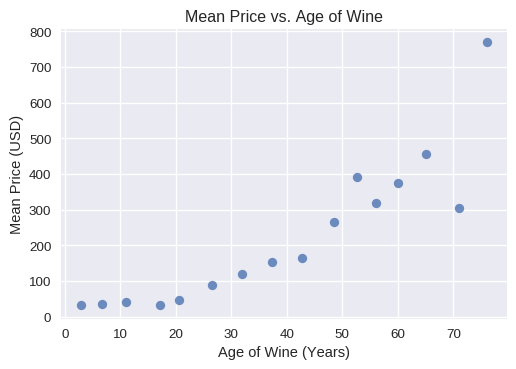

In [28]:
ax = sns.regplot(groups['age'], groups['price'], fit_reg=False)
ax.set(xlabel='Age of Wine (Years)', ylabel='Mean Price (USD)')
plt.title('Mean Price vs. Age of Wine')
plt.show()

No surprises here: older wine does generally cost more. However, let's see if people are really tasting the age of the wine. We'll try to explore this relationship in more depth.

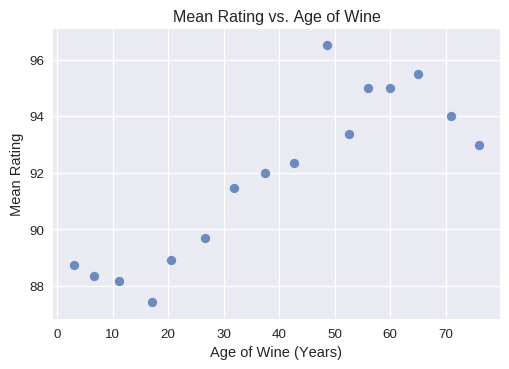

In [29]:
ax = sns.regplot(groups['age'], groups['points'], fit_reg=False)
ax.set(xlabel='Age of Wine (Years)', ylabel='Mean Rating')
plt.title('Mean Rating vs. Age of Wine')
plt.show()

The behavior here is a bit more interesting–reviewers appear to rate wine that is at least 20 years old differently than wine that isn't. What is even more interesting is that there appears to be distinct trends for both segments. We'll attempt to fit this using a regression that takes into account the piecewise nature of the relationship.

But first, let's check how ratings are distributed over each age group with a strip plot.

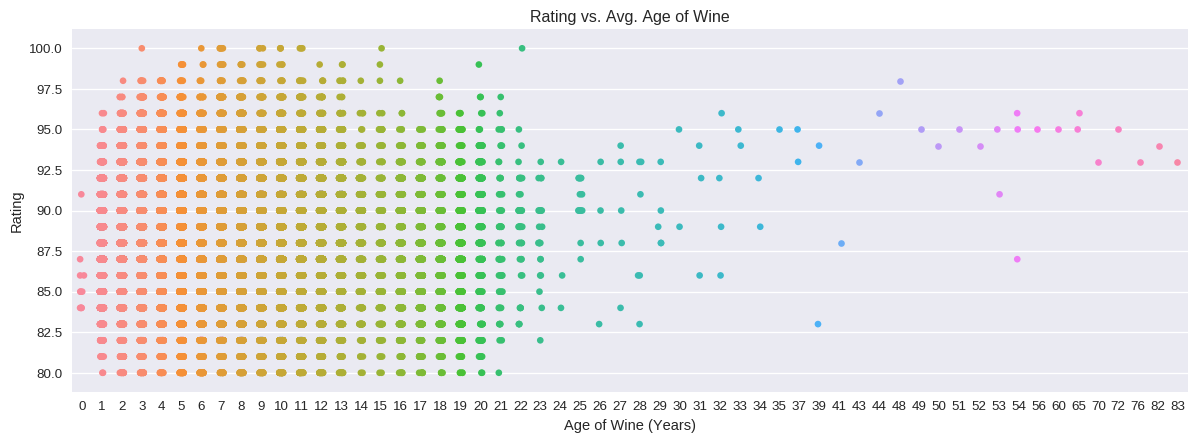

In [30]:
plt.figure(figsize=(15, 5))
ax = sns.stripplot(x='age', y='points', data=data, jitter=True)
ax.set(xlabel='Age of Wine (Years)', ylabel='Rating')
plt.title('Rating vs. Avg. Age of Wine')
plt.show()

It's pretty apparent that most of the data is for wine that is less than 21 years old. We'll use this as the cutoff for our piecewise regression.

But first, let's look at a naive linear regression on the entire set of data:

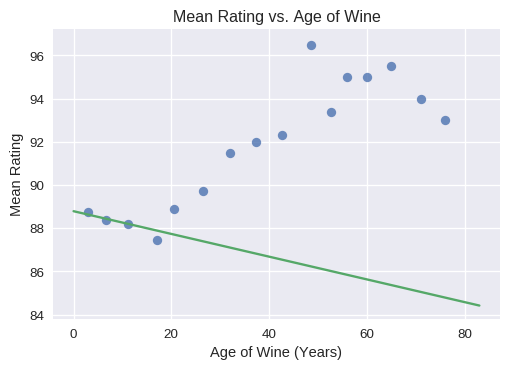

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 points   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     428.8
Date:                Sat, 16 Dec 2017   Prob (F-statistic):           4.65e-95
Time:                        12:23:40   Log-Likelihood:            -2.7437e+05
No. Observations:              107672   AIC:                         5.487e+05
Df Residuals:                  107670   BIC:                         5.488e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     88.7859      0.019   4740.526      0.000      88.749      88.823
age           -0.0526      0.003    -20.706      0.000      -0.058      -0.048
==============================================================================
Omnibus:                      768.699   Durbin-Watson:                   1.069
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              548.867
Skew:                           0.058   Prob(JB):                    6.53e-120
Kurtosis:                       2.670   Cond. No.                         14.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [31]:
data = data.sort_values(['age', 'price'])
fit = smf.ols(formula='points ~ age', data=data).fit()

fig = plt.figure()
ax = sns.regplot(groups['age'], groups['points'], fit_reg=False)
ax.plot(data['age'], fit.predict())
ax.set(xlabel='Age of Wine (Years)', ylabel='Mean Rating')
plt.title('Mean Rating vs. Age of Wine')
plt.show()
fit.summary()

Compare this with a piecewise regression using an interaction term that describes if a wine is at least 21 years old–Wines less than 21 years old are a assigned a value of 0 while older wines are assigned the residue from 21. It also looks like we have diminishing returns with older wines, so we'll guess that it fits closer to the square root of the residual age:

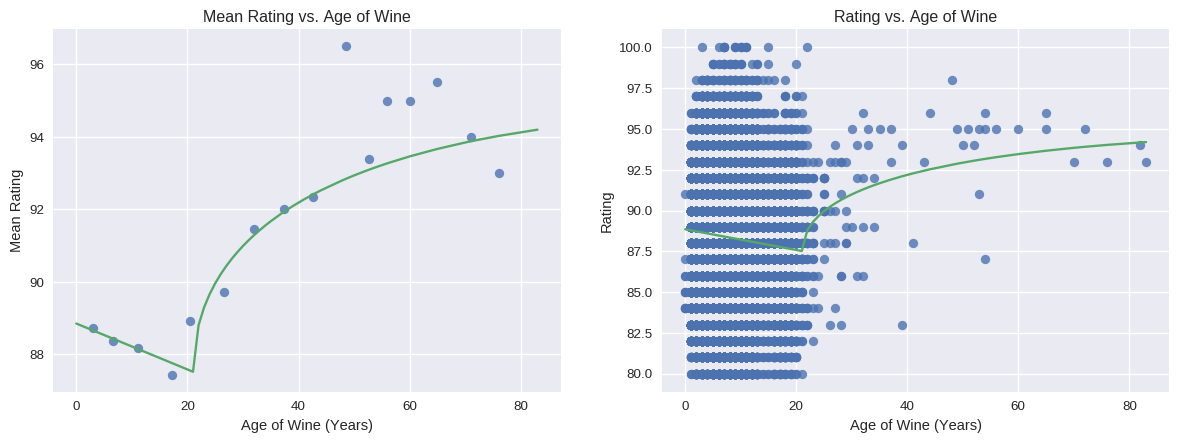

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 points   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                     331.7
Date:                Sat, 16 Dec 2017   Prob (F-statistic):          2.38e-144
Time:                        12:23:42   Log-Likelihood:            -2.7425e+05
No. Observations:              107672   AIC:                         5.485e+05
Df Residuals:                  107669   BIC:                         5.485e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              88.8494      0.019   4636.076      0.000      88.812      88.887
age                    -0.0633      0.003    -24.042      0.000      -0.068      -0.058
np.sqrt(age_21plus)     1.3467      0.088     15.289      0.000       1.174       1.519
==============================================================================
Omnibus:                      789.892   Durbin-Watson:                   1.072
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              560.841
Skew:                           0.058   Prob(JB):                    1.64e-122
Kurtosis:                       2.666   Cond. No.                         69.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [32]:
data['age_21plus'] = data.apply(lambda x: x.age - 21 if x.age >= 21 else 0, axis=1)
fit_piecewise = smf.ols(formula='points ~ age + np.sqrt(age_21plus)', data=data).fit()

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15, 5))

sns.regplot(groups['age'], groups['points'], fit_reg=False, ax=ax1)
ax1.plot(data['age'], fit_piecewise.predict(), color=sns.color_palette()[1])
ax1.set(xlabel='Age of Wine (Years)', ylabel='Mean Rating')
ax1.set_title('Mean Rating vs. Age of Wine')

sns.regplot(data['age'], data['points'], fit_reg=False, color=sns.color_palette()[0], ax=ax2)
ax2.plot(data['age'], fit_piecewise.predict(), color=sns.color_palette()[1])
ax2.set(xlabel='Age of Wine (Years)', ylabel='Rating')
ax2.set_title('Rating vs. Age of Wine')

plt.show()
fit_piecewise.summary()

## Hypothesis Testing

Qualitatively, our piecewise regression doesn't look too bad! Our R<sup>2</sup> still isn't very good at all, but that is expected since the ratings for young wine were all over the place. We've lowered the F critical value (a.k.a. F statistic) to 331.7, and as a result our _p_-value is _many_ orders smaller. In fact, it's smaller than any reasonable alpha level we could have originally chosen, and for this reason we can confidently reject the null hypothesis. Wine age and rating are probably correlated, and we have a decent model to show it.

It's also important to note that we did not overfit our model. Just for fun, let's try adding an interaction term with the price since we know it reacts similarly to the age:

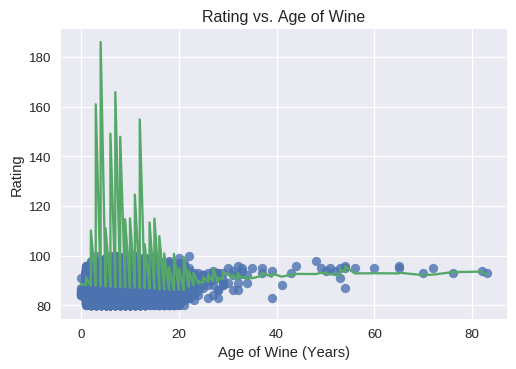

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 points   R-squared:                       0.185
Model:                            OLS   Adj. R-squared:                  0.185
Method:                 Least Squares   F-statistic:                     4892.
Date:                Sat, 16 Dec 2017   Prob (F-statistic):               0.00
Time:                        12:23:43   Log-Likelihood:            -2.6356e+05
No. Observations:              107672   AIC:                         5.271e+05
Df Residuals:                  107666   BIC:                         5.272e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                    88.0119      0.023   3879.089      0.000      87.967      88.056
age                          -0.1070      0.003    -34.170      0.000      -0.113      -0.101
np.sqrt(age_21plus)           1.5432      0.127     12.148      0.000       1.294       1.792
price                         0.0277      0.000     61.688      0.000       0.027       0.029
age:price                     0.0005   5.87e-05      9.002      0.000       0.000       0.001
np.sqrt(age_21plus):price    -0.0088      0.001    -14.042      0.000      -0.010      -0.008
==============================================================================
Omnibus:                    46053.496   Durbin-Watson:                   1.349
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          3229526.717
Skew:                          -1.212   Prob(JB):                         0.00
Kurtosis:                      29.720   Cond. No.                     9.14e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.14e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [33]:
fit_piecewise = smf.ols(formula='points ~ (age + np.sqrt(age_21plus)) * price', data=data).fit()

fig = plt.figure()
ax = sns.regplot(data['age'], data['points'], fit_reg=False)
ax.plot(data['age'], fit_piecewise.predict())
ax.set(xlabel='Age of Wine (Years)', ylabel='Rating')
plt.title('Rating vs. Age of Wine')
plt.show()
fit_piecewise.summary()

Here we've clearly overfitted the model. We've included the full set of reviews instead of the 5-year averages in the plot to show how the model attempts to fit every point. Our R<sup>2</sup> is much better now, so it's nice to see that we were right in guessing that factoring in the price would provide a better fit. However, with only a few variables at play here, the model is too complicated to be trusted.

## Summary

`some1 else do dis im tired`  
but maybe talk about how we could have improved our model by incorporating machine learning or something